In [1]:
from scripts.data_processing.load_files import FileManager
from scripts.data_processing.image_loader import ImageLoader
from scripts.data_processing.onion_processor import OnionProcessor
from scripts.data_processing.pls_processor import PLSProcessor
from scripts.data_processing.dataset_balancer import HyperspectralDatasetBalancer
from scripts.model_training.model_trainer import ModelTrainer
from scripts.model_evaluation.model_evaluator import ModelEvaluator
from scripts.model_evaluation.prediction_visualizer import ImageTesterAndVisualizer
from scripts.utils.class_distribution import ClassDistribution

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
# Folderpad waar de subfolders zich bevinden
base_folder_path = "./data/Definitieve Dataset v4 Gesplitst"

# Initialize file instance
print("Test Dataset")
test_file_manager = FileManager(f"{base_folder_path}/test")
test_files, test_labels, test_png_files = test_file_manager.get_images_and_labels()

Test Dataset
Subfolder goed heeft 11 TIFF-afbeeldingen
Subfolder goed heeft 7 PNG-afbeeldingen (Gesneden Uien)
Subfolder interne rot heeft 14 TIFF-afbeeldingen
Subfolder interne rot heeft 14 PNG-afbeeldingen (Gesneden Uien)
Subfolder doorschot heeft 7 TIFF-afbeeldingen
Subfolder doorschot heeft 7 PNG-afbeeldingen (Gesneden Uien)


In [3]:
# Print de distributie
test_class_distribution = ClassDistribution(test_labels)
test_class_distribution.print_distribution("Distributie van Test")

Distributie van Test
Class doorschot: 7
Class goed: 11
Class interne rot: 14




In [4]:
# Laad afbeeldingen
image_loader= ImageLoader()
test_images = image_loader.load_images(test_files)

Dimensies van de afbeeldingen: {(128, 128, 224)}


In [5]:
# Verwerk de afbeeldingen per dataset in pixels waarbij we alleen de uien pixels krijgen
processor = OnionProcessor()
test_extracted_pixels, test_pixel_labels, test_masks = processor.process_images(test_images, test_labels)

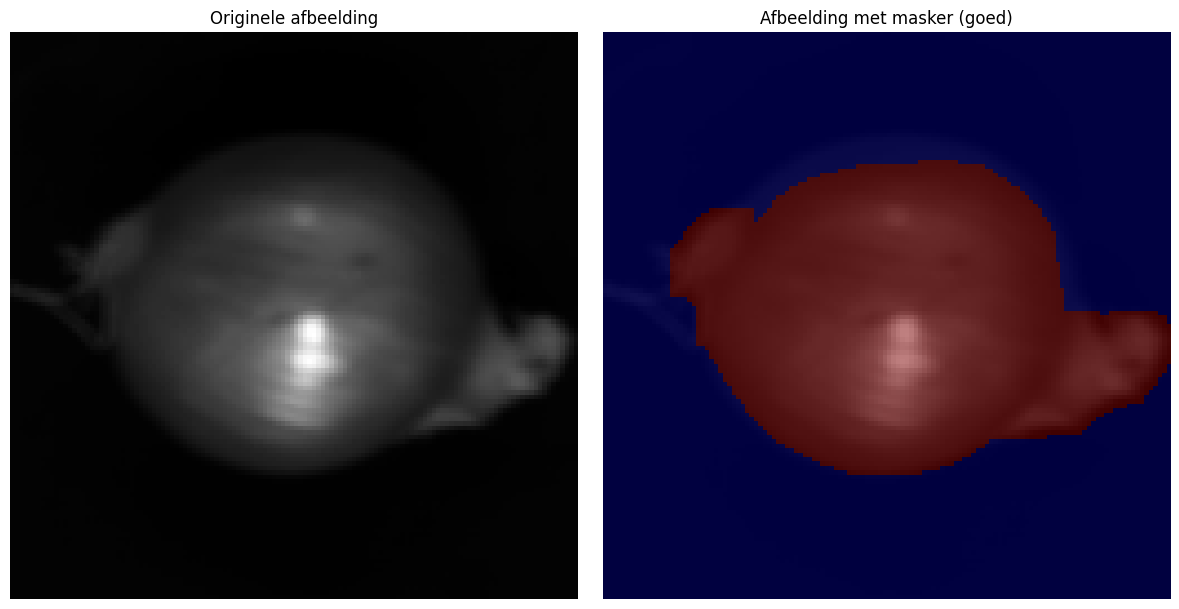

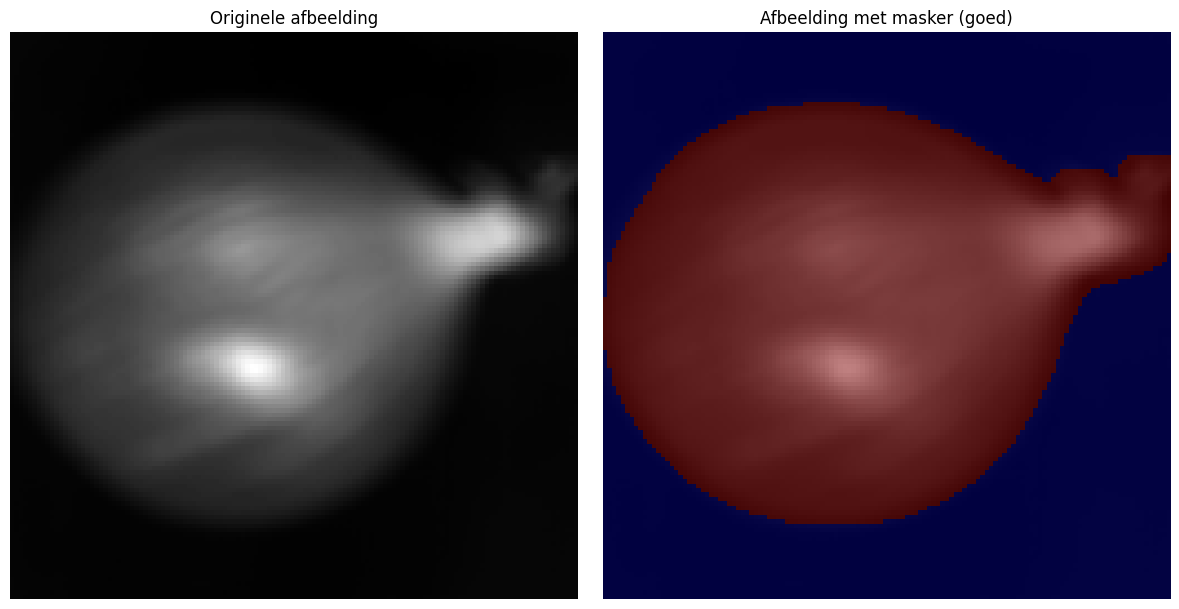

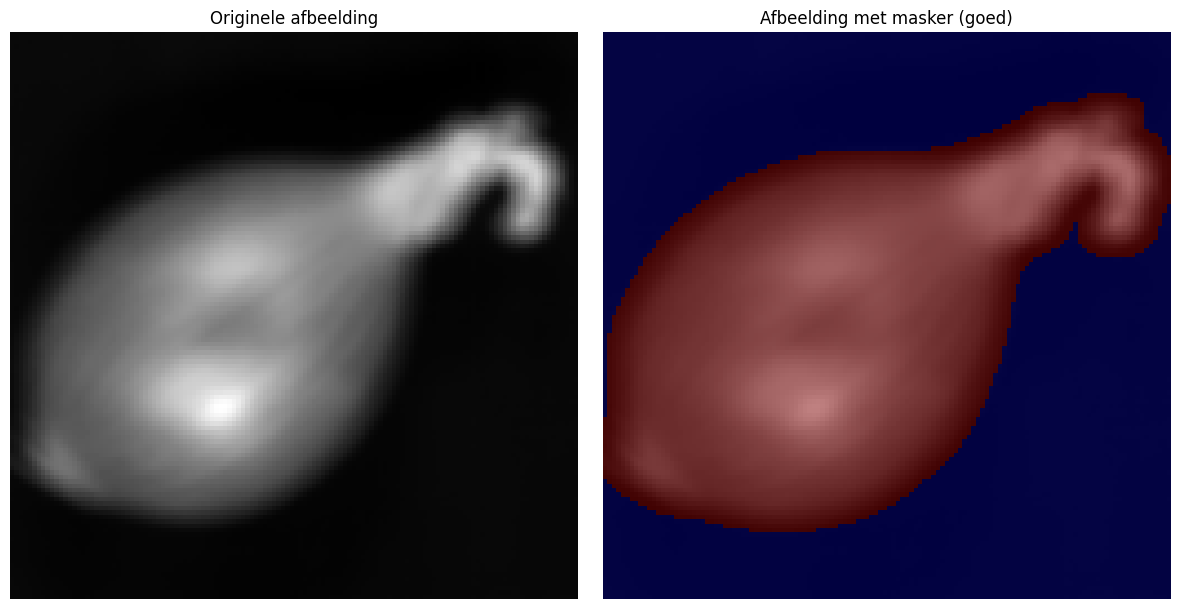

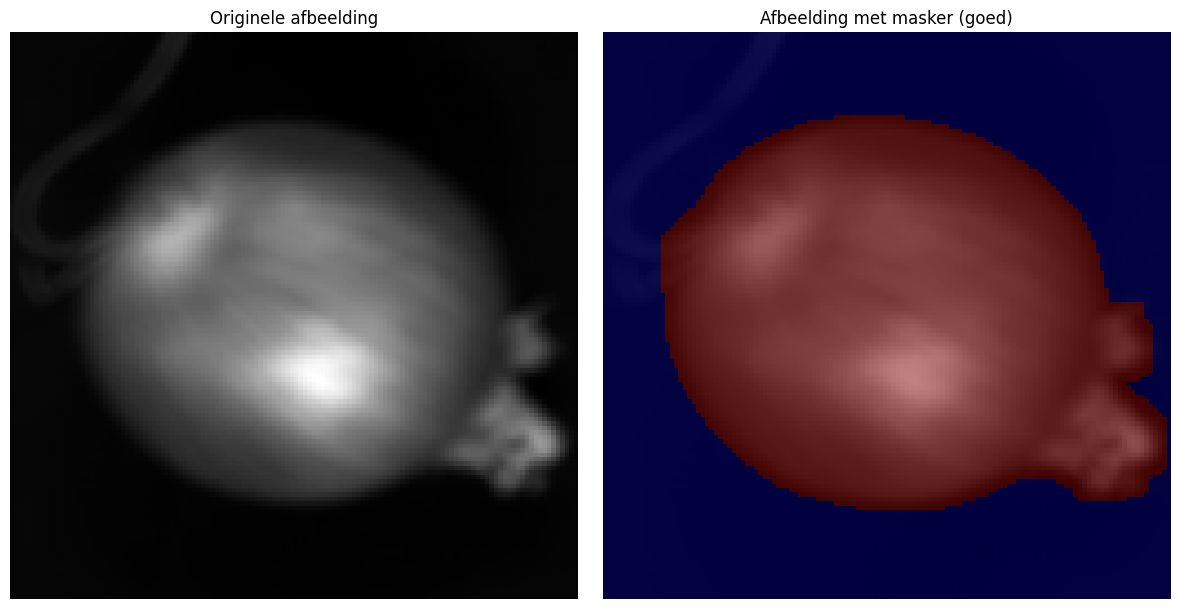

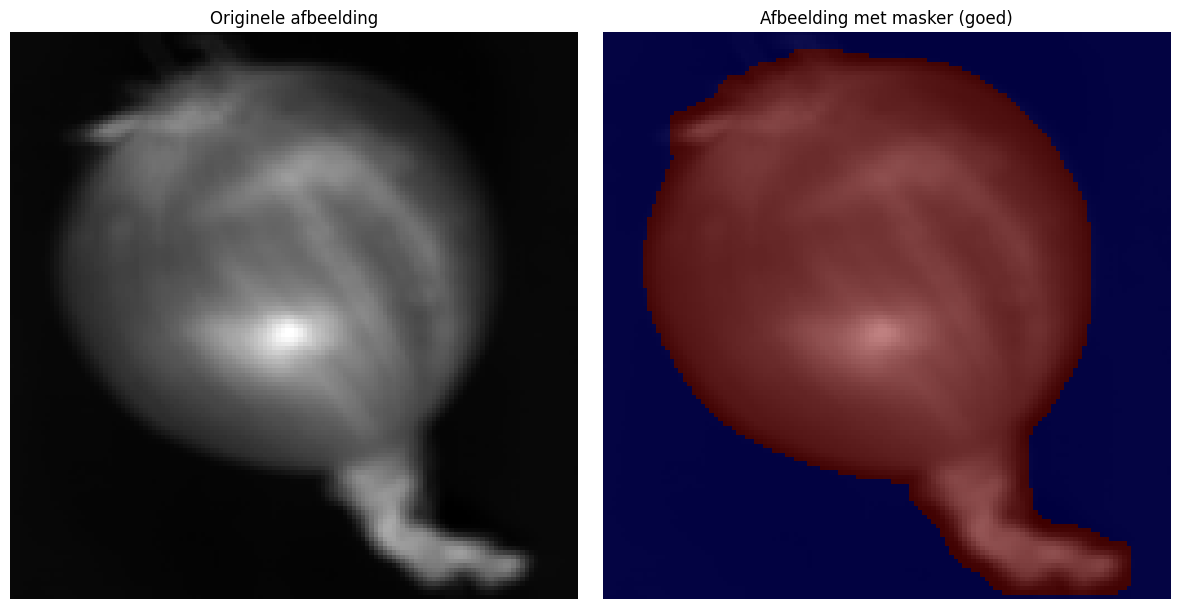

In [11]:
processor.plot_sample_images(test_images, test_labels, test_masks, max_images=5)

In [6]:
# Initialiseer en gebruik de processor
pls_processor = PLSProcessor()
pls_model = pls_processor.load_model('models/pls_model.joblib')
scaler = pls_processor.load_model('models/scaler.joblib')
label_encoder = pls_processor.load_model('models/label_encoder.joblib')

# Transformeer de testdata
test_pixels_pls, test_labels_encoded = pls_processor.transform(pls_model, scaler, label_encoder, test_extracted_pixels, test_pixel_labels)

In [ ]:
# Initialiseer ModelTrainer en train
trainer = ModelTrainer()
trained_model = trainer.load_model('models/xgb_model.joblib')

# Evalueer het model op train- en testdata
test_accuracy = trainer.evaluate(trained_model, test_pixels_pls, test_labels_encoded)

print("Test Pixel-Based Accuracy:", test_accuracy)

Test Pixel-Based Accuracy: 0.584012466130317


In [8]:
# Initialiseer ModelEvaluator
evaluator = ModelEvaluator(scaler, pls_model, label_encoder, trained_model)

# Evalueer het model op afbeeldingsniveau
image_accuracy, report, correct_classifications = evaluator.evaluate(test_images, test_labels, test_masks)

# Print de resultaten
evaluator.print_results(image_accuracy, report, correct_classifications)

Totaal aantal afbeeldingen: 32
Aantal correct geclassificeerde afbeeldingen: 26
Afbeeldingsnauwkeurigheid: 81.25%

Classificatierapport per klasse:
              precision    recall  f1-score   support

   doorschot       0.62      0.71      0.67         7
        goed       1.00      0.73      0.84        11
 interne rot       0.81      0.93      0.87        14

    accuracy                           0.81        32
   macro avg       0.81      0.79      0.79        32
weighted avg       0.84      0.81      0.81        32



Pixel Accuracy for image label 'goed': 83.12%


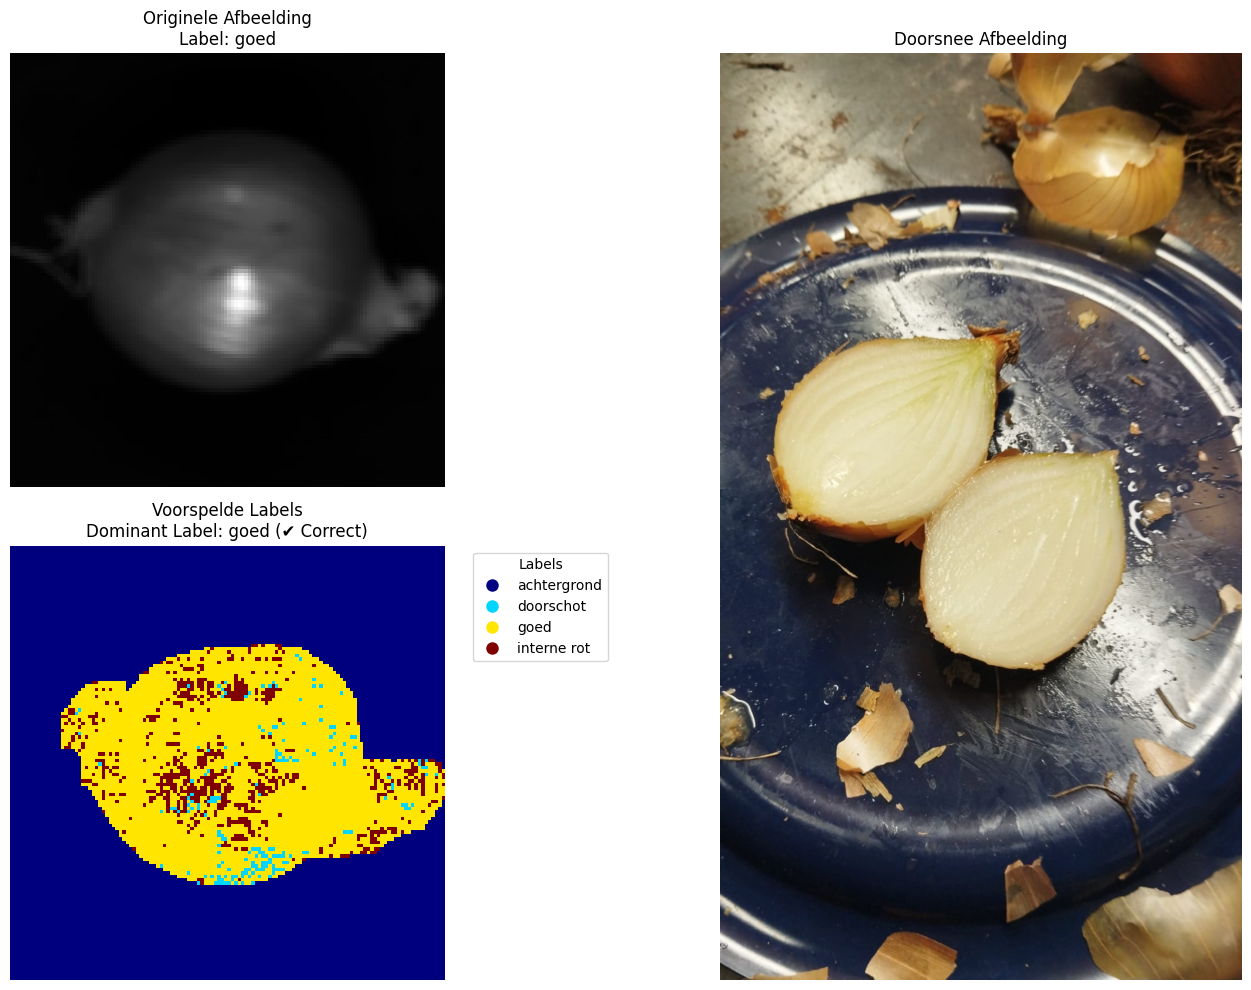

Pixel Accuracy for image label 'goed': 28.05%


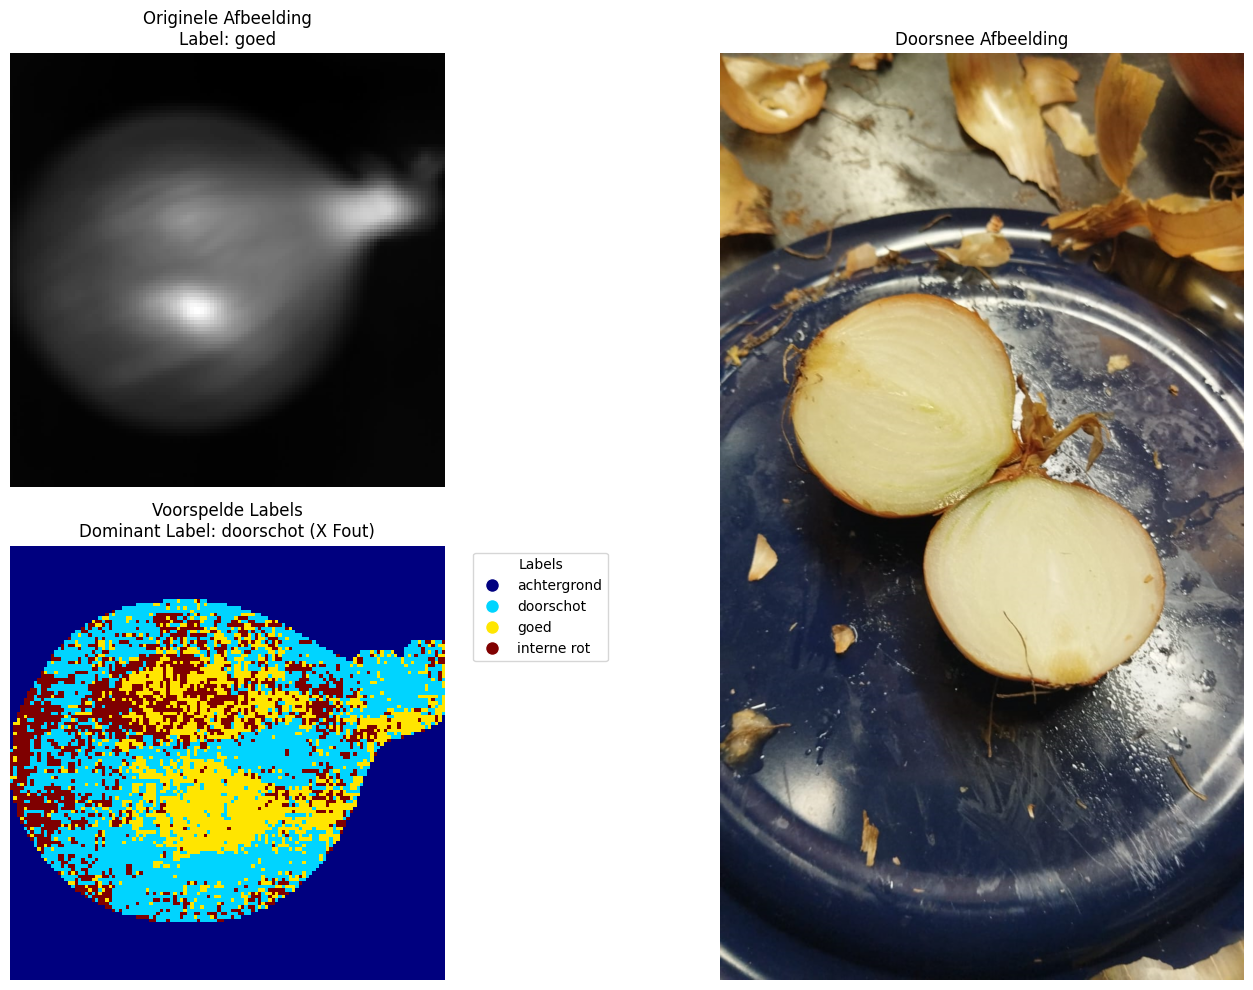

Pixel Accuracy for image label 'goed': 50.10%


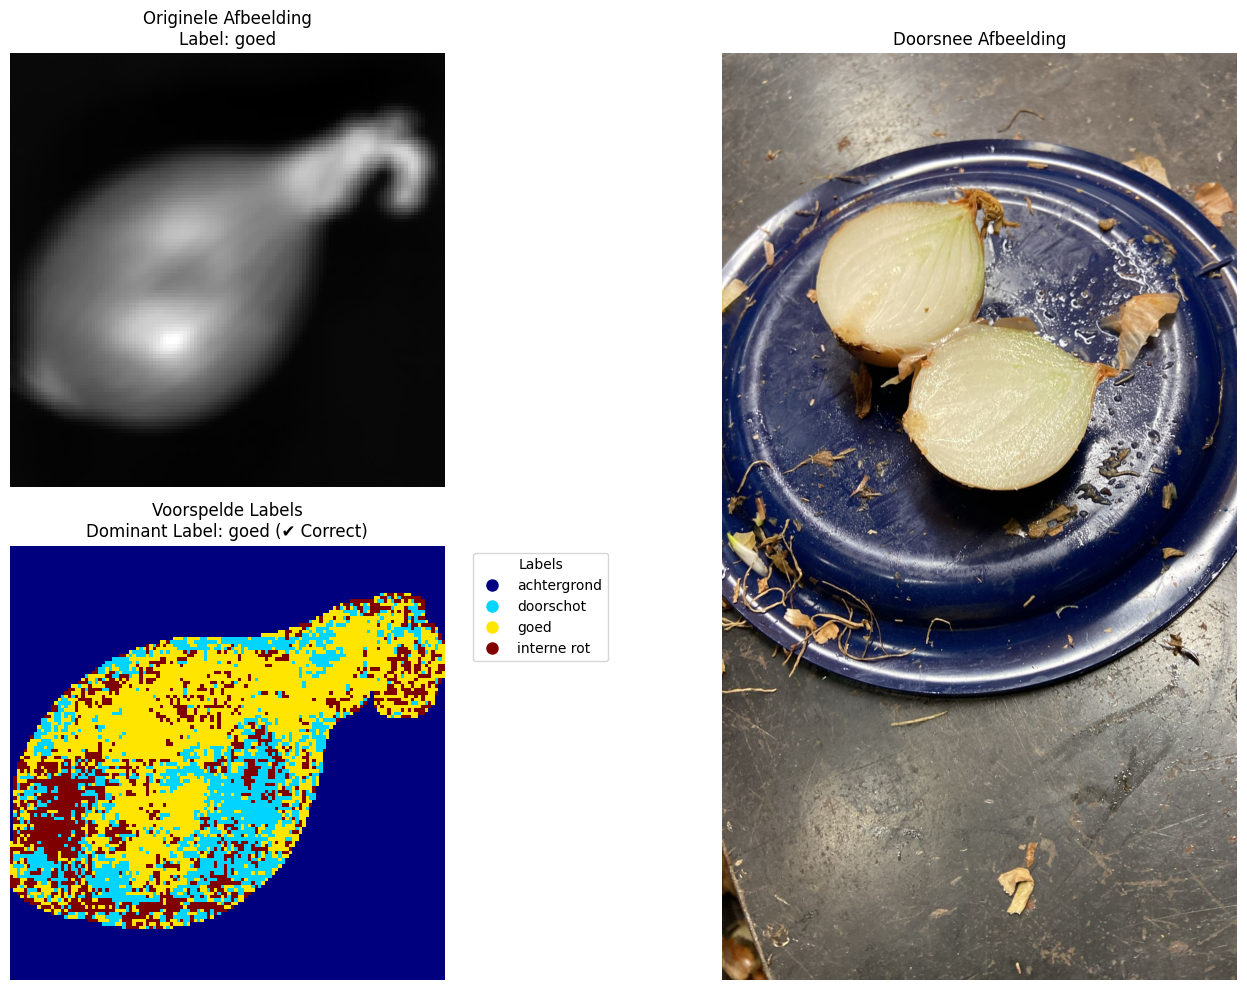

Pixel Accuracy for image label 'goed': 51.42%


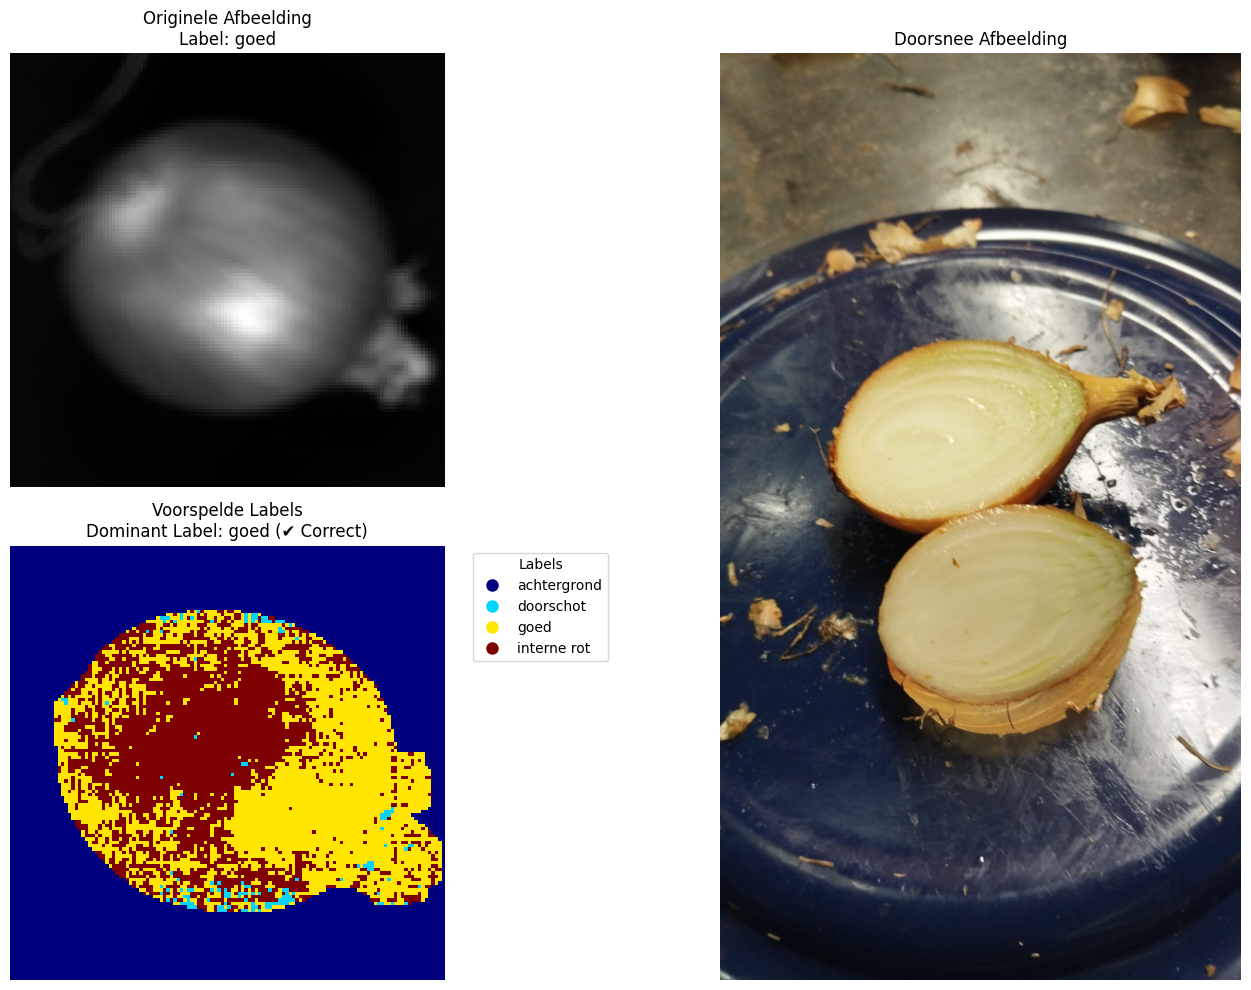

Pixel Accuracy for image label 'goed': 62.78%


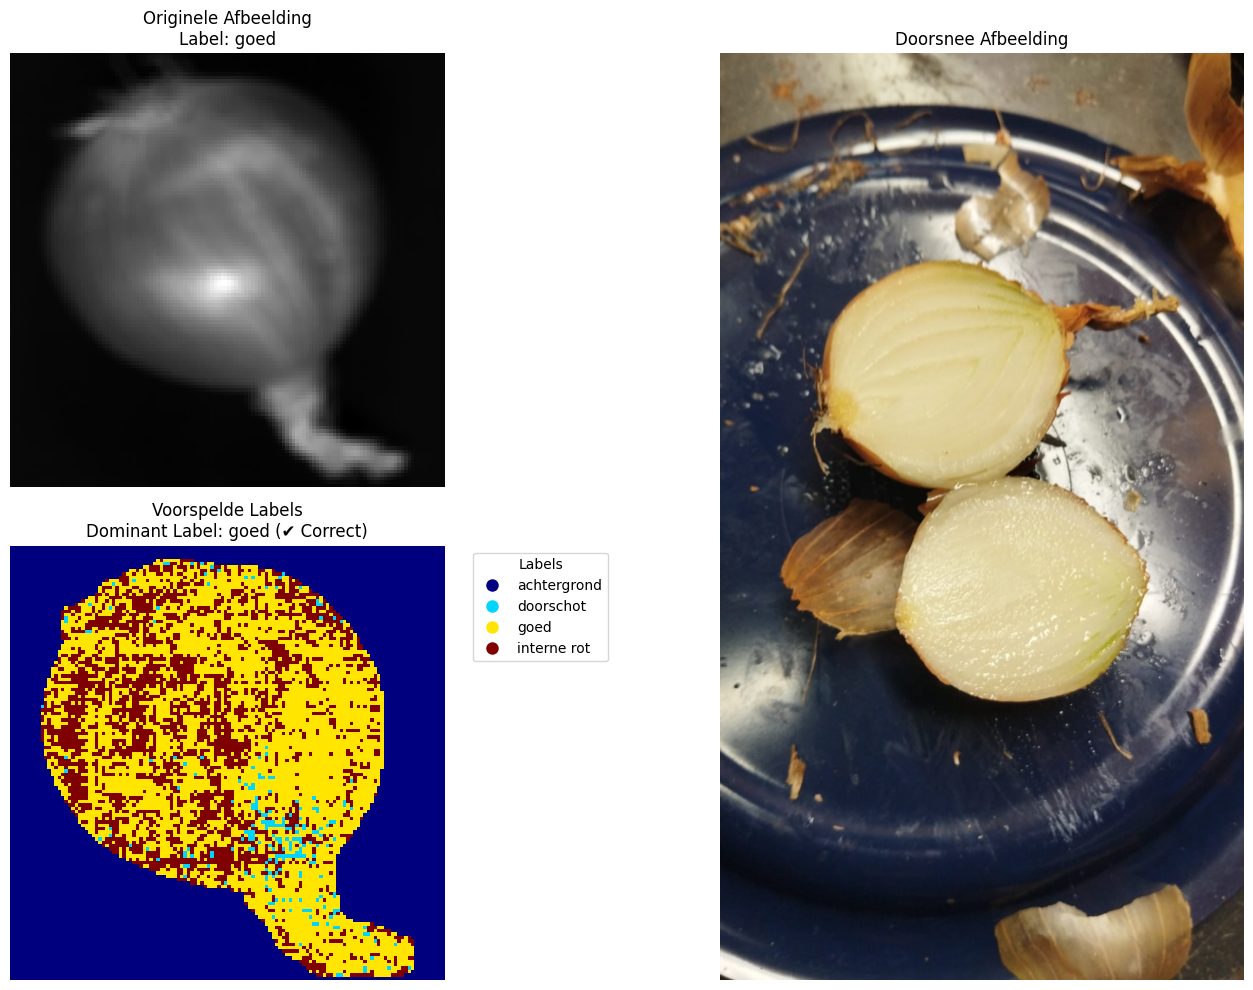

In [12]:
# Stel de klasse in met model, scaler, pls, en label_encoder
tester = ImageTesterAndVisualizer(trained_model, scaler, pls_model, label_encoder)

# Test en visualiseer maximaal 5 afbeeldingen
tester.test_and_visualize_images(test_images, test_labels, test_masks, test_png_files, sort_cmap='jet', max_images=5)